# Advanced Lane Finding
The goals / steps of this project are the following:

1. Compute the **camera calibration** matrix and distortion coefficients given a set of chessboard images.
1. Apply a **distortion** correction to raw images.
1. Use color transforms, gradients, etc., to **create a thresholded binary image**.
1. Apply a perspective transform to rectify binary image (**"birds-eye view"**).
1. Detect lane pixels and fit to **find the lane boundary**.
1. Determine the **curvature** of the lane and vehicle position with respect to center.
1. **Warp** the detected lane boundaries back onto the original image.
1. **Output** visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Camera calibration
First, I'll compute the camera calibration matrix and distortion coefficients using chessboard images.


In [51]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read the list of calibration images
image_paths = glob.glob('camera_cal/calibration*.jpg') 

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in calibration image 

# object points
chessboard_x = 9
chessboard_y = 6
objp = np.zeros((chessboard_y*chessboard_x,3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_x,0:chessboard_y].T.reshape(-1,2)

# Go through every image
for image_path in image_paths:
    img =  cv2.imread(image_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chessboard_x,chessboard_y),None)

    # Save corners to arrays
    if True == ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw corners
        img = cv2.drawChessboardCorners(img, (chessboard_x, chessboard_y), corners, ret)
        saved_image = image_path.replace('camera_cal', 'output_images/draw_camera_cal')
        plt.imsave(saved_image, img)
        #plt.imshow(img)
        #plt.savefig(saved_image)

# Calibrating camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)



## 2. Distortion correction 
## 3. Create thresholded binary image
Use color transforms, gradients, etc., to create a thresholded binary image.

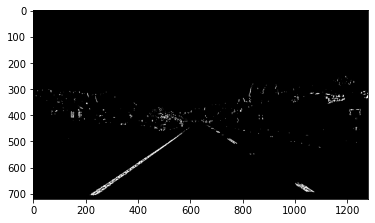

In [55]:
# Go through every test image for undistortion and create thresholded binary image
test_image_paths = glob.glob('test_images/*.jpg') 
for test_image_path in test_image_paths:
    test_img = cv2.imread(test_image_path)

    # Distortion correction
    undist = cv2.undistort(test_img, mtx, dist, None, mtx)
    saved_undist_path = test_image_path.replace('test_images/', 'output_images/undist/undist_')
    #print(saved_undist_path)
    #cv2.imwrite(saved_undist_path,undist)


    ### Begin for creating thresholded binary image
    hls = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    # Sobel Operator in x direction
    sobel_x = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobel_x)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Apply threshold for sobel in x direction
    sobelx_thresh = [70, 170]
    sobelx_binary = np.zeros_like(scaled_sobel)
    sobelx_binary[(scaled_sobel > sobelx_thresh[0]) & (scaled_sobel < sobelx_thresh[1])] = 1
    
    # Apply threshold for color channel (in s channel)
    channel_thresh = [170, 255]
    channel_binary = np.zeros_like(s_channel)
    channel_binary[(s_channel > channel_thresh[0])&(s_channel < channel_thresh[1])] = 1

    # get new binary image by combining two binary image
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(sobelx_binary == 1) | (channel_binary == 1)] = 1
    plt.imshow(combined_binary, cmap='Greys_r')

    # Save the combined binary image
    saved_binary_path = test_image_path.replace('test_images/', 'output_images/binary/binary_')
    #print(saved_binary_path)
    cv2.imwrite(saved_binary_path,combined_binary*255)
    ### Finish for creating thresholded binary image




## 4. Birds-eye view
Apply the transform to every undisort image and save it to **birds_eye** folder.

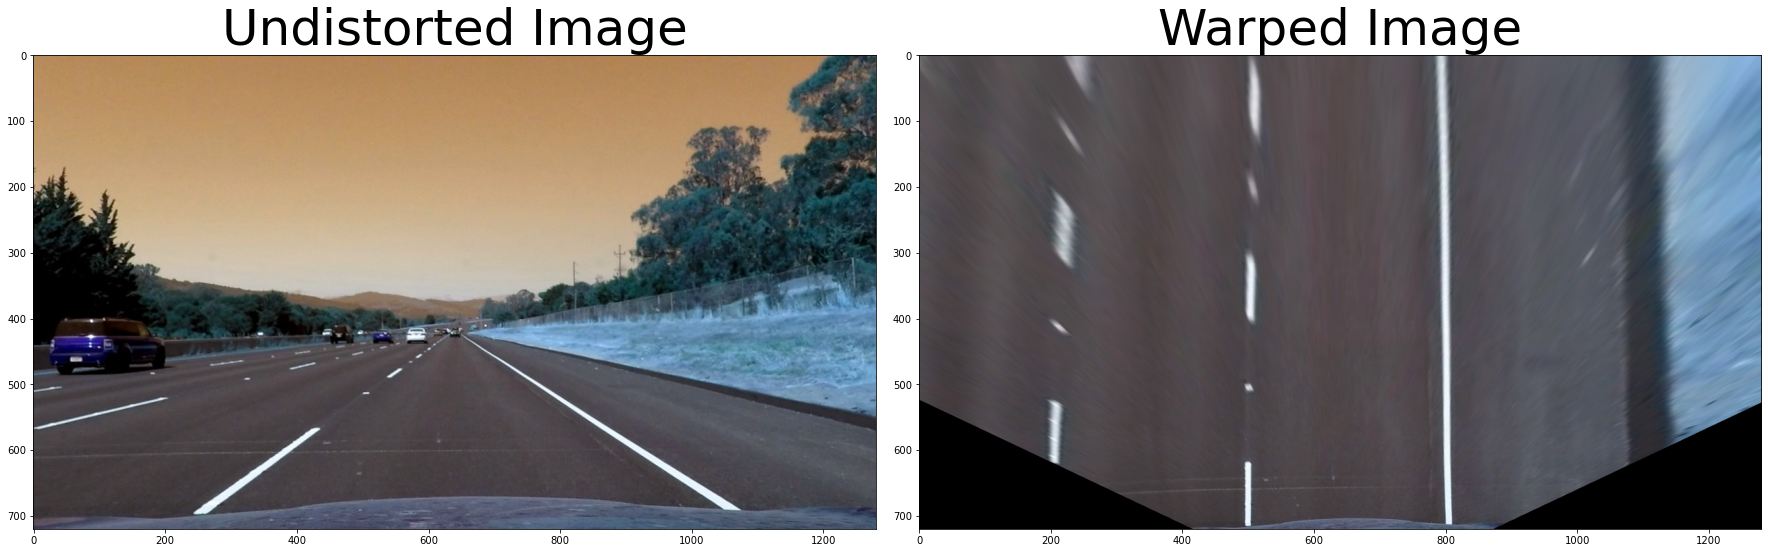

In [92]:

# Read one undistort image
undis_image_path = "output_images/undist/undist_straight_lines2.jpg"
undis_image = cv2.imread(undis_image_path)
gray = cv2.cvtColor(undis_image, cv2.COLOR_BGR2GRAY)
# Define 4 source points 
test1_src = np.float32([[499, 530], [844, 530], [1008, 630], [362, 630]]) #test1.jpg
straight2_src = np.float32([[557, 475], [729, 475], [961, 630], [345, 630]]) #test1.jpg
src = straight2_src

# Define 4 destination points 
test1_dst = np.float32([[500, 550], [800, 550], [800, 630], [500, 630]])
straight2_dst = np.float32([[500, 300], [800, 300], [800, 680], [500, 680]])

dst = straight2_dst
# Get the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# Get the birds-eye view image

warped_image = cv2.warpPerspective(undis_image, M, undis_image.shape[1::-1], flags=cv2.INTER_LINEAR)
# Save the image
warped_image_path = undis_image_path.replace('undist', 'warped')
cv2.imwrite(warped_image_path,warped_image)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undis_image)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(warped_image)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




## 5. Find the lane boundary
Detect lane pixels and fit to find the lane boundary.

## 6. Determine the curvature


## 7. Warp


## 8. Output
